**Table Of Contents:**
* Importing packages and modules
* Text data preprocessing
* Basic EDA with WordCloud and Plotly
* Machine Learning:
    * Logistic Regression
    * Support Vector Machine
    * Multinomial Naive Bayes
    * Decision Tree Classifier
    * AdaBoost Classifier   
    * Random Forest Classifier
    * XGBoost Classifier
    * XGBClassifier Hyperparameter tuning
* Deep Learning:
    * Text data preprocessing
    * Bidirectional LSTM with own Embeddings
    * Bidirectional LSTM with GloVe
    
References used are mentioned whereever required.

Classification objective: To classify insincere quiestion.
How can we find insincere question?

Some characteristics that can signify that a question is insincere: ( As given in the website)

    1)Has a non-neutral tone
        Has an exaggerated tone to underscore a point about a group of people
        Is rhetorical and meant to imply a statement about a group of people
    2)Is disparaging or inflammatory
        Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
        Makes disparaging attacks/insults against a specific person or group of people
        Based on an outlandish premise about a group of people
        Disparages against a characteristic that is not fixable and not measurable
    3)Isn't grounded in reality
        Based on false information, or contains absurd assumptions
    Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers


In [1]:
import numpy as np 
import pandas as pd
import plotly.offline as py
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,roc_curve,make_scorer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import os
import scikitplot as skplt
import seaborn as sns
import time
print(os.listdir("../input"))
stopwords=set(stopwords.words('english'))
stemmer=SnowballStemmer('english')
seed=5

['train.csv', 'test.csv', 'sample_submission.csv', 'embeddings']


In [2]:
print("Number of stopwords:",len(stopwords))

Number of stopwords: 179


In [3]:
#This kernel is run on kaggle gpu. Hence loading data online.
data=pd.read_csv('../input/train.csv')
test=pd.read_csv('../input/test.csv')
sub=pd.read_csv('../input/sample_submission.csv')
data.head() # Lets see some samples

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
data.shape 

(1306122, 3)

Thus we have quite a large dataset. large enough to train deep learning models. However since the intention of this kernel is to learn existing methods and modern methods. We will also consider ML based models.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [6]:
data.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

Therefore, There is no null in the data.

In [7]:
target_count=data.target.value_counts()
target_count.index

Int64Index([0, 1], dtype='int64')

In [8]:
target_count=data.target.value_counts()
trace1=go.Bar(x=target_count.index,
             y=target_count.values,
             name='Target Counts',
             marker=dict(color='rgba(0,255,255,0.5)',
                         line=dict(color='rgb(0,0,0)',width=0.5)),
             text=['Sincere Questions','Insincere Questions'])
layout=go.Layout(title='Bar plot of target counts',
                xaxis=dict(title='Target'),
                yaxis=dict(title='Number of questions'))
plt_data=[trace1]
fig=dict(data=plt_data,layout=layout)
iplot(fig)

Clearly the data is highly imbalanced. For the baseline model, even if predict always 0, we would be correct (1225312/1306122)*100 = 93.81 percent of time.!!!

Also, using accuracy as a measure of correctness in such dataset can be higly misleading.
F1 score given a more accurate measure in such cases:
The references for it are given as follows:

f1 score, precision and recall:
1)https://www.youtube.com/watch?v=Z9NZY3ej9yY
2)https://www.youtube.com/watch?v=dbrRsqlof4w


Data- Pre-processing for Training Machine Learning models.
First we fix the data imbalance issue. Since we have sufficient data samples for Target 0. We sample equal amount of sample for Target 1 and create a dataset with a ratio of 50:50 Targets.

In [9]:
target1=data[data['target']==1]
target0=data[data['target']==0]
sampled_size=target1.shape[0]
sampled_target0=target0.sample(sampled_size,random_state=seed)
new_data=pd.concat([target1,sampled_target0],axis=0)
#Shuffling the data
new_data=new_data.sample(frac=1,random_state=seed).reset_index(drop=True)

In [10]:
sampled_size # For each targets

80810

In [11]:
new_data.head() # Combined data with samples shuffled

,qid,question_text,target
0,b54dbc3bca0d2780b06e,Why are some people very strange and highly hy...,0
1,30ff2ebb239497b194ba,Should I fire someone who unnecessarily wrote ...,0
2,fad82a91611d5fa16c1f,Where can I get a SEO article to write and get...,0
3,9e66a1060693a5ac1ebe,Why do theists get annoyed with atheists?,1
4,48a7e093f2389ae656ca,Have you ever seen a Jew eat something secretl...,1


1. * * next we tokenize the data. Have a look at what tokenize does.

In [12]:
word_tokenize("Helloo world world")

['Helloo', 'world', 'world']

have a look at punctuations

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

1. lets see an example of stemming # There are covered in the NLP basics blog linked in the beginning.

In [14]:
list_words=["walking","versions","goes","mountaineer"]
print("Before Stemming: After Stemming")
for i in range(len(list_words)):
    print(list_words[i],":",stemmer.stem(list_words[i]),"\n")

Before Stemming: After Stemming
walking : walk 

versions : version 

goes : goe 

mountaineer : mountain 



[](http://)Joining the filtered( Tokenized and stemmed) words into sentences,eg

In [15]:
text="hai miss, hope you are doing great. All the best"
tokenized_words=word_tokenize(text)
filtered_words=[word.lower() for word in tokenized_words if ((word.lower() not in string.punctuation) &
                                                             (word.lower() not in stopwords))]
stemmed_words=[stemmer.stem(word) for word in filtered_words]
print(' '.join(filtered_words))

hai miss hope great best


Finally, we write a general function to do above functions:
ie. removing stop words and punctuation, followed by stemming.

In [16]:
def filter_text(text):
    tokenized_words=word_tokenize(text)
    filtered_words=[word.lower() for word in tokenized_words if ((word.lower() not in string.punctuation) &
                                                                 (word.lower() not in stopwords))]
    stemmed_words=[stemmer.stem(word) for word in filtered_words]
    return ' '.join(filtered_words)

1. Creat a copy and Apply it on the copied data

In [17]:
trad_data=new_data.copy()
trad_data['question_text']=trad_data['question_text'].apply(lambda x: filter_text(x))


lets Do some Exploratory Data analysis to get some intution/insights on the data.
Build a function to show the most frequent words and their magnitude

In [18]:
def plot_wordcloud(text,max_font_size=40,max_words=100):
    plt.figure(figsize=(15,10))
    wordcloud=WordCloud(max_font_size=max_font_size,max_words=max_words,random_state=seed)
    plot=wordcloud.generate(text)
    plt.imshow(plot)
    plt.axis('off')
    plt.show()
    

Combine words from all the sentences of class 0 to create wordcloud.
Similarly repeat for class 1 as well . Plot 2 plots for each the targets.

In [19]:
target0=trad_data[trad_data['target']==0].reset_index(drop=True) #Reset the index once you sample
target1=trad_data[trad_data['target']==1].reset_index(drop=True)

target0_text=''
target1_text=''
for i in range(target0.shape[0]):
    target0_text+=target0.question_text[i] # Combine all the words
for i in range(target1.shape[0]):
    target1_text+=target1.question_text[i]


"target0_text" contains all the words in the sentences which have Target 0. Similarly for target 1 as well

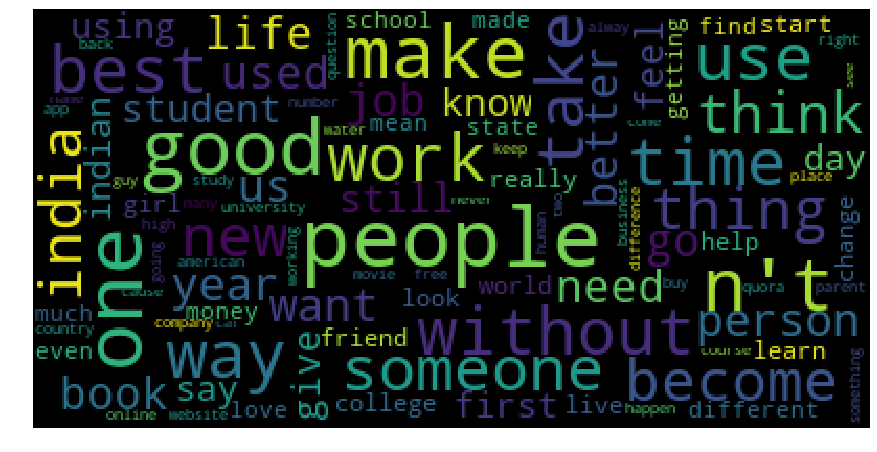

In [20]:
plot_wordcloud(target0_text)

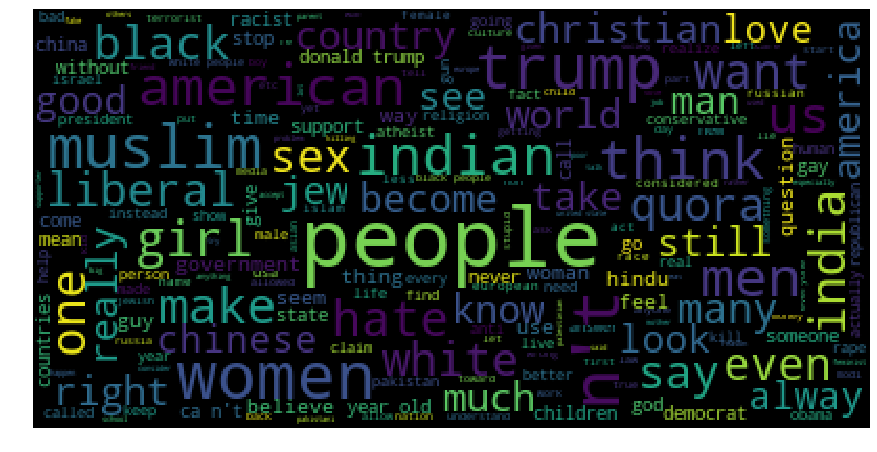

In [21]:
plot_wordcloud(target1_text,max_words=200)

Considering mulitple consequetive words can yeild better intution.
Lets have a look at N-grams 

In [22]:
def plot_top_ngrams(text,ngrams=(1,1),top=10,max_features=10000,color='rgba(0,255,255,0.5)',name="N-gram"):
    cv=CountVectorizer(ngram_range=ngrams,max_features=max_features)
    trans_text=cv.fit_transform(text)
    col_sum=trans_text.sum(axis=0)
    word_index=[(word,col_sum[0,idx]) for word,idx in cv.vocabulary_.items()]
    sorted_word_index=sorted(word_index,key=lambda x:x[1],reverse=True)
    top_words_index=sorted_word_index[:top]
    top_words=[element[0] for element in top_words_index]
    counts=[element[1] for element in top_words_index]
    trace1=go.Bar(x=top_words,
                 y=counts,
                 marker=dict(color=color,
                             line=dict(color='rgb(0,0,0)',width=0.5)))
    layout=go.Layout(title='{}'.format(name),
                    xaxis=dict(title='Ngrams'),
                    yaxis=dict(title='Counts of words'))
    plot_data=[trace1]
    fig=dict(data=plot_data,layout=layout)
    iplot(fig)
    
    
    
    

In [23]:
plot_top_ngrams(target1.question_text,ngrams=(1,1),top=30,color='rgba(128,0,0,0.5)',name="Top 1-grams for Target 1")

In [24]:
plot_top_ngrams(target1.question_text,ngrams=(2,2),top=30,name="Top 2-grams for Target 1")

In [25]:
plot_top_ngrams(target1.question_text,ngrams=(3,3),top=30,color='rgba(128,128,128,0.5)',name="Top 3-grams for Target 1")


In [26]:
plot_top_ngrams(target0.question_text,ngrams=(1,1),top=30,color='rgba(128,0,0,0.5)',name="Top 1-grams for Target 0")

In [27]:
plot_top_ngrams(target0.question_text,ngrams=(2,2),top=30,name="Top 2-grams for Target 0")

In [28]:
plot_top_ngrams(target0.question_text,ngrams=(3,3),top=30,color='rgba(128,128,128,0.5)',name="Top 3-grams for Target 0")

In [29]:
trad_data.shape # consists of both targets 0 and 1.

(161620, 3)

Lets create a train-test split

In [30]:
#Reduce Dataset for testing purpose
mini_df=trad_data.sample(2000,random_state=seed) #For qucik testing .
X=trad_data['question_text']
Y=trad_data['target']

train_X,val_X,train_y,val_y=train_test_split(X,Y,test_size=0.2,random_state=seed)


In [31]:
print("Train shape",train_X.shape)
print("Test shape",val_X.shape)

Train shape (129296,)
Test shape (32324,)


For vectorizing: We try out 2 methods:
        1)Count 
        2)TFID

* Lets start with count vectorizer first up: With 3-gram max.

In [32]:
cv=CountVectorizer(ngram_range=(1,3),analyzer='word')
train_X_cv=cv.fit_transform(train_X.values)
val_X_cv=cv.transform(val_X.values)


In [33]:
train_X_cv

<129296x1377683 sparse matrix of type '<class 'numpy.int64'>'
	with 2558310 stored elements in Compressed Sparse Row format>

Exploring what a Sparse represention is:

In [34]:
sparse_matrix=cv.fit_transform(["Hi man how are you"])

In [35]:
sparse_matrix

<1x12 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

cv.fit_transform(["Hi man how are you"]) Gernerates <1x12 sparse matrix of type '<class 'numpy.int64'>'	with 12 stored elements in Compressed Sparse Row format>

https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)

In this case the CSR representation contains 13 entries, compared to 16 in the original matrix. The CSR format saves on memory only when NNZ < (m (n − 1) − 1) / 2. Another example, the matrix

    ( 10 20 0 0 0 0 0 30 0 40 0 0 0 0 50 60 70 0 0 0 0 0 0 80 ) {\displaystyle {\begin{pmatrix}10&20&0&0&0&0\\0&30&0&40&0&0\\0&0&50&60&70&0\\0&0&0&0&0&80\\\end{pmatrix}}} {\begin{pmatrix}10&20&0&0&0&0\\0&30&0&40&0&0\\0&0&50&60&70&0\\0&0&0&0&0&80\\\end{pmatrix}}

is a 4 × 6 matrix (24 entries) with 8 nonzero elements, so

    A = [ 10 20 30 40 50 60 70 80 ]
   IA = [  0  2  4  7  8 ]
   JA = [  0  1  1  3  2  3  4  5 ]   

The whole is stored as 21 entries.

    IA splits the array A into rows: (10, 20) (30, 40) (50, 60, 70) (80);
    JA aligns values in columns: (10, 20, ...) (0, 30, 0, 40, ...)(0, 0, 50, 60, 70, 0) (0, 0, 0, 0, 0, 80)

In [36]:
print(sparse_matrix)

  (0, 7)	1
  (0, 10)	1
  (0, 4)	1
  (0, 1)	1
  (0, 6)	1
  (0, 9)	1
  (0, 3)	1
  (0, 11)	1
  (0, 0)	1
  (0, 5)	1
  (0, 8)	1
  (0, 2)	1


In [37]:
train_X_cv.shape

(129296, 1377683)

In [38]:
tsvd=TruncatedSVD(n_components=50,random_state=seed)
train_X_svd=tsvd.fit_transform(train_X_cv)
val_X_svd=tsvd.transform(val_X_cv)
tsne=TSNE(n_components=2,random_state=seed)
train_X_tsne=tsne.fit_transform(train_X_svd)

(model.predict_proba) gives you the probabilities for the target (0 and 1 in your case) in array form.

**Confusion matrix:**
A confusion matrix is a summary of prediction results on a classification problem.
The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.
The confusion matrix shows the ways in which your classification model is confused when it makes predictions.
It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

**AUC-ROC**
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [39]:
def get_model(model,train_X,train_y,val_X):
    model.fit(train_X,train_y)
    pred_probs=model.predict_proba(val_X)
    pred_train=model.predict(train_X)
    pred_val=model.predict(val_X)
    score_train=f1_score(train_y,pred_train)
    score_val=f1_score(val_y,pred_val)
    return pred_probs,pred_train,pred_val,score_train,score_val

def get_confusion_matrix(val_y,pred,title):
    cm=confusion_matrix(val_y,pred)
    plt.figure(figsize=(10,5))
    sns.heatmap(cm,annot=True)
    plt.title(title)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()
    
def get_roc_curve(val_y,pred_probs,title):
    plt.title(title)
    skplt.metrics.plot_roc(val_y,pred_probs)
    
    

In [40]:
models=[LogisticRegression(random_state=seed),MultinomialNB(),DecisionTreeClassifier(random_state=seed),
        AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=100,learning_rate=0.1,random_state=seed),
        RandomForestClassifier(n_estimators=100,max_depth=3,random_state=seed),
        XGBClassifier(random_state=seed)]
model_names=['LR','Multinomial NB','DTC','ABC','RFC','XGBC']

In [41]:
pred_probs={}
pred_train={}
pred_val={}
score_train={}
score_val={}
k=0
for i in range(len(models)):
    k=k+1
    print("Model Number:",k)
    pred_probs[model_names[i]],pred_train[model_names[i]],pred_val[model_names[i]],\
    score_train[model_names[i]],score_val[model_names[i]]=get_model(models[i],train_X_cv,train_y,val_X_cv)
    


scl=StandardScaler()                                                     
train_X_scl_cv=scl.fit_transform(train_X_svd)
val_X_scl_cv=scl.transform(val_X_svd)
pred_probs['SVC'],pred_train['SVC'],pred_val['SVC'],\
score_train['SVC'],score_val['SVC']=get_model(SVC(probability=True,random_state=seed),
                                                      train_X_scl_cv,train_y,val_X_scl_cv)

Model Number: 1


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Model Number: 2
Model Number: 3
Model Number: 4
Model Number: 5
Model Number: 6


In [42]:
trace1=go.Bar(x=list(score_train.keys()),
              y=list(score_train.values()),
             name='Training Score with CV',
             marker=dict(color='rgba(0,255,0,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))
trace2=go.Bar(x=list(score_val.keys()),
              y=list(score_val.values()),
             name='Validation Score with CV',
             marker=dict(color='rgba(255,255,0,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))

layout=go.Layout(barmode='group',
                title='Scores of Different Models')
plot_data=[trace1,trace2]
fig=dict(data=plot_data,layout=layout)
iplot(fig)

Clearly, LogisticRegression, Multinomial NB and DecisionTree Classifier overfit the data. AdaBoost, RandomForest and XGB Classifiers do not overfit but their scores are low compared to the former 3 models. Regularization and Hyperparameter tuning can surely help to not overfit in case of initial 3 models and can help the latter 3 models to improve their scores,respectively.

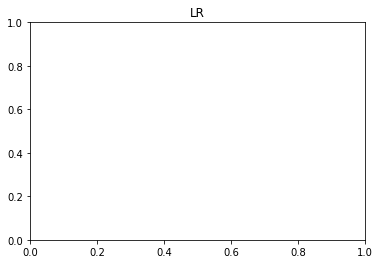

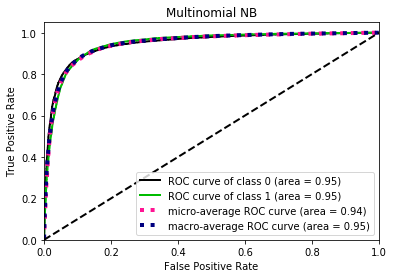

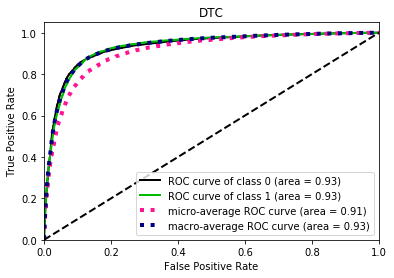

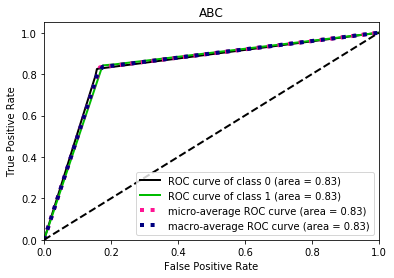

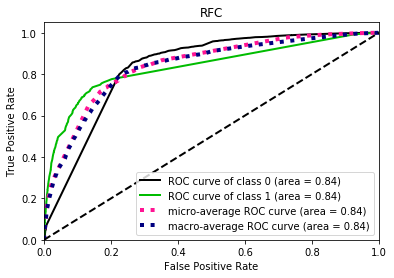

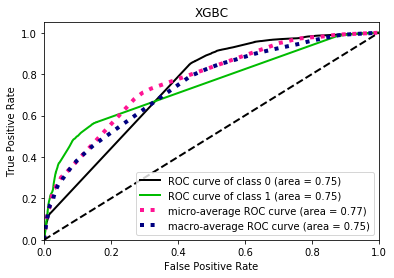

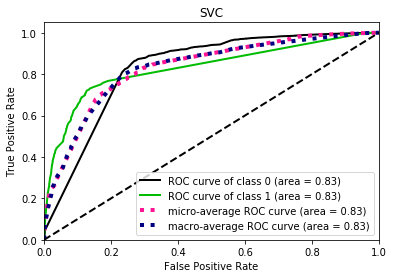

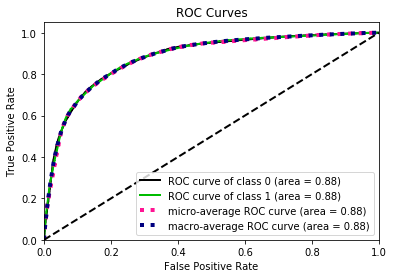

In [43]:
for model,probs in pred_probs.items():
    get_roc_curve(val_y,probs,model)
    

I don't know what is the problem with roc curve for LR. It is printed at the bottom with title ROC Curves. Multinomial NB and Decision Tree Classifier seem to perform best. 

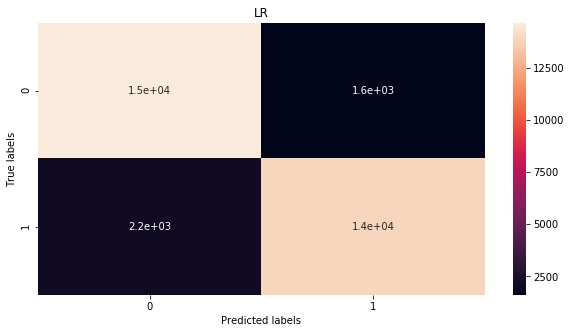

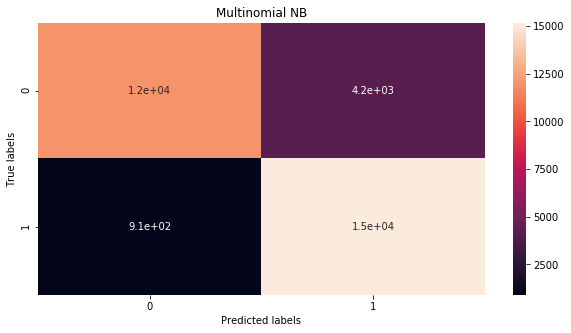

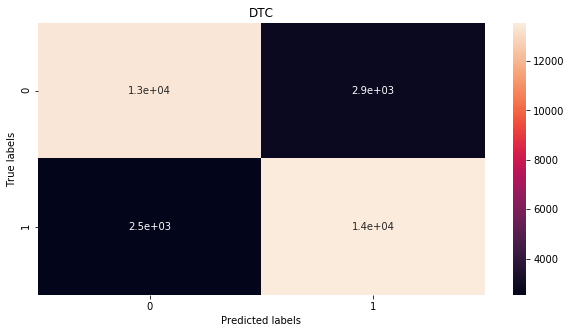

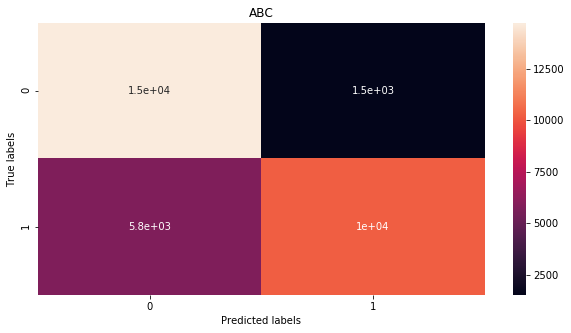

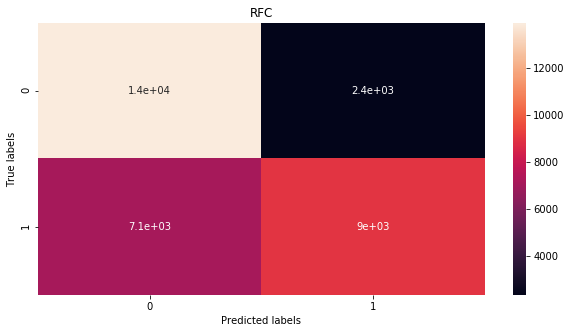

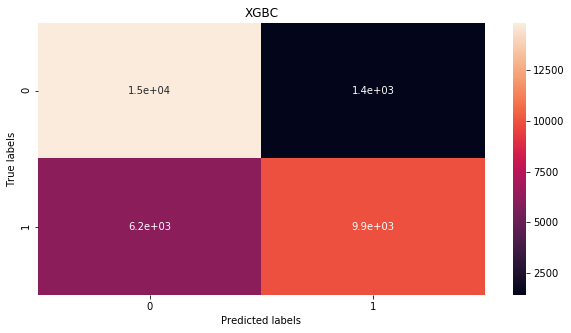

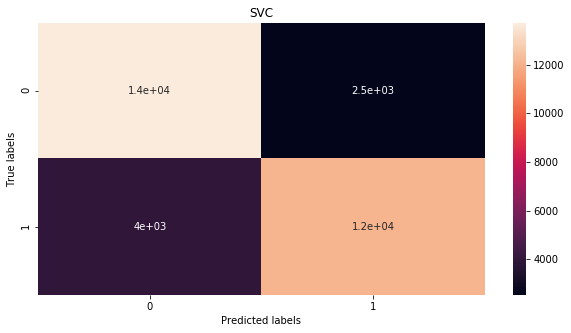

In [44]:
for model,pred in pred_val.items():
    get_confusion_matrix(val_y,pred,model)

From the confusion matrix of Multinomial NB and Decision Tree Classifier, we see that MNB has higher misclassification of 'Sincere Questions' and lower misclassification of 'Insincere Questions' as compared to DTC.
DTC has large misclassification of 'Insincere Questions'. This is not at all desired. Practically speaking, it is better to misclassify true 'Sincere Question' than to misclassify true 'Insincere Question'. In case of classification of true 'Insincere Question', MNB performs best while RFC performs worst. 

tfv=TfidfVectorizer(ngram_range=(1,3),analyzer='word',min_df=3)
train_X_tfv=tfv.fit_transform(train_X.values)
val_X_tfv=tfv.transform(val_X.values)
tsvd_tfv=TruncatedSVD(n_components=50,random_state=seed)
train_X_svd_tfv=tsvd_tfv.fit_transform(train_X_tfv)
val_X_svd_tfv=tsvd_tfv.transform(val_X_tfv)
tsne_tfv=TSNE(n_components=2,random_state=seed)
train_X_tsne_tfv=tsne_tfv.fit_transform(train_X_svd_tfv)


df=pd.DataFrame()
df['tsne1']=pd.Series(train_X_tsne_tfv[:,0])
df['tsne2']=pd.Series(train_X_tsne_tfv[:,1])
df['target']=train_y
sns.scatterplot(df['tsne1'],df['tsne2'],hue='target',data=df)
plt.show()

pred_probs_tfv={}
pred_train_tfv={}
pred_val_tfv={}
score_train_tfv={}
score_val_tfv={}

for i in range(len(models)):
    pred_probs_tfv[model_names[i]],pred_train_tfv[model_names[i]],pred_val_tfv[model_names[i]],\
    score_train_tfv[model_names[i]],score_val_tfv[model_names[i]]=get_model(models[i],train_X_tfv,train_y,val_X_tfv)

scl=StandardScaler()
train_X_scl_tfv=scl.fit_transform(train_X_svd_tfv)
val_X_scl_tfv=scl.transform(val_X_svd_tfv)
pred_probs_tfv['SVC'],pred_train_tfv['SVC'],pred_val_tfv['SVC'],\
score_train_tfv['SVC'],score_val_tfv['SVC']=get_model(SVC(probability=True,random_state=seed),
                                                      train_X_scl_tfv,train_y,val_X_scl_tfv)



In [45]:

trace1=go.Bar(x=list(score_train_tfv.keys()),
              y=list(score_train_tfv.values()),
             name='Training Score with TFV',
             marker=dict(color='rgba(0,255,0,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))
trace2=go.Bar(x=list(score_val_tfv.keys()),
              y=list(score_val_tfv.values()),
             name='Validation Score with TFV',
             marker=dict(color='rgba(255,255,0,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))

layout=go.Layout(barmode='group',
                title='Scores of Different Models')
plot_data=[trace1,trace2]
fig=dict(data=plot_data,layout=layout)
iplot(fig)

NameError: name 'score_train_tfv' is not defined

With the use of TfidfVectorizer, overfitting is not observed in LR and Multinomial NB models unlike during usage of CountVectorizer. Overfitting of DTC still remains an issue. Other models aren't overfitting. It looks like Multinomial NB is the best model. But we haven't yet tuned hyperparameters of tree based models. In the following graphs, we compare the training scores of models with CountVectorizer vs with TfidfVectorizer. Same is done for validation scores as well.

trace1=go.Bar(x=list(score_train.keys()),
              y=list(score_train.values()),
             name='Training Score with CV',
             marker=dict(color='rgba(0,0,255,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))
trace2=go.Bar(x=list(score_train_tfv.keys()),
              y=list(score_train_tfv.values()),
             name='Training Score with TFV',
             marker=dict(color='rgba(255,0,0,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))

layout=go.Layout(barmode='group',
                title='Training Scores of Different Models')
plot_data=[trace1,trace2]
fig=dict(data=plot_data,layout=layout)
iplot(fig)

In [46]:
trace1=go.Bar(x=list(score_train.keys()),
              y=list(score_train.values()),
             name='Training Score with CV',
             marker=dict(color='rgba(0,0,255,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))
trace2=go.Bar(x=list(score_train_tfv.keys()),
              y=list(score_train_tfv.values()),
             name='Training Score with TFV',
             marker=dict(color='rgba(255,0,0,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))

layout=go.Layout(barmode='group',
                title='Training Scores of Different Models')
plot_data=[trace1,trace2]
fig=dict(data=plot_data,layout=layout)
iplot(fig)

NameError: name 'score_train_tfv' is not defined

When switched from CountVectorizer to TfidfVectorizer, the training scores of LR and Multinomial NB have decreased, while that of other models it has increased. 

trace1=go.Bar(x=list(score_val.keys()),
              y=list(score_val.values()),
             name='Validation Score with CV',
             marker=dict(color='rgba(0,0,255,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))
trace2=go.Bar(x=list(score_val_tfv.keys()),
              y=list(score_val_tfv.values()),
             name='Validation Score with TFV',
             marker=dict(color='rgba(255,0,0,0.5)',
                        line=dict(color='rgb(0,0,0)',width=1.5)))

layout=go.Layout(barmode='group',
                title='Validation Scores of Different Models')
plot_data=[trace1,trace2]
fig=dict(data=plot_data,layout=layout)
iplot(fig)

When switched from CountVectorizer to TfidfVectorizer, there is either a slight decrease or increase in validation scores. Increase in the validation score of RFC is huge.  

for model,probs in pred_probs_tfv.items():
    get_roc_curve(val_y,probs,model)

From ROC Curves, it looks like Multinomial NB and DTC are best models. Let us check their confusion matrices.

for model,pred in pred_val_tfv.items():
    get_confusion_matrix(val_y,pred,model)
    

Classification of true 'Insincere Questions' is highest in Multinomial NB and least in RFC. Again, Multinomial NB with TfidfVectorizer seems to be the best model.

Let us try to tune the hyperparameters of XGBClassifier. 

start=time.time()
params={'n_estimators':[100,500],
       'learning_rate':[0.01,0.1],
       'subsample':[0.8]}

model=XGBClassifier(random_state=seed)
score=make_scorer(f1_score)
grid=GridSearchCV(model,params,cv=3,scoring=score)
grid.fit(train_X_tfv,train_y)

end=time.time()
print('Total time taken: ' + str(end-start))

print(grid.best_params_)
print(grid.best_score_)
xgb1=grid.best_estimator_
xgb1.fit(train_X_tfv,train_y)
pred1=xgb1.predict(val_X_tfv)
score1=f1_score(val_y,pred1)
print(score1)

Little bit of tuning has increased our score by 4.5%. The best part is, it is not even overfitting.

In [47]:
#start=time.time()
#params={'n_estimators':[500,800,1000],
#       'learning_rate':[0.1,0.15,0.2],
#       'subsample':[0.8],
#       'max_depth':[3,5,7],
#       'gamma':[0,10]}

#model=XGBClassifier(random_state=seed)
#score=make_scorer(f1_score)
#grid2=GridSearchCV(model,params,cv=3,scoring=score)
#grid2.fit(train_X_tfv,train_y)

#end=time.time()
#print('Total time taken: ' + str(end-start))

#0.8397122528906257
#{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 800, 'subsample': 0.8}
#Total time taken: 8327.329408407211

In [48]:
#print(grid2.best_score_)
#print(grid2.best_params_)
#xgb2=grid2.best_estimator_
#xgb2.fit(train_X_tfv,train_y)
#pred2=xgb2.predict(val_X_tfv)
#score2=f1_score(val_y,pred2)
#print(score2)

#0.8397122528906257
#{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 800, 'subsample': 0.8}
#0.8515138946495231

Thus, by further parameter tuning we have increased XGBClassifier score by 7%.

Hence we have analysed various ML models and Tuned one of them. 
In the next notebook we have a look at Deep Learning based methods.